<a href="https://colab.research.google.com/github/AndreaDiTrani/Decepticon-adversarial-attack/blob/main/JSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i tackle the JSS problem from start to finish via quantum annealing.

At the moment the workflow is:



*   Instance generation
*   QUBO fomrulation with timespan discrimination
*   ILP via disjunctive formulation
*   Pruning
*   Default embedding and compilation
*   IP embedding
*   Template embedding
*   Problem solution using quantum annealing on QPU
*   Problem solution with GAMA algorithm (not feasible for almost any size)
*   Solution visualization

Next steps are:

*   Fault tolerant Template embedding
*   Full application workflow of Template embedding

In progress:

*   Embedding testing



#**IMPORTS**

In [2]:
!pip install dwave-ocean-sdk
!pip install gurobipy
!pip install pyqubo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 25.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
   

In [57]:
import networkx as nx
import random
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import copy
import itertools
from itertools import product
import pickle

import pyqubo
from pyqubo import Binary, SubH

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go
import dwave.inspector
import minorminer
import dwave_networkx as dnx
import neal

from dwave.embedding import pegasus
from dwave.cloud import Client

import gurobipy as gb
from gurobipy import GRB

In [58]:
from google.colab import drive
drive.mount('/content/drive')

lic_path = '/content/drive/MyDrive/Uni/' #path to gurobi and D-Wave licenses

with open(lic_path + 'gurobi.lic','r') as f:
  lic = f.read()

ls = lic.split('\n')
access_id = ls[3].split('=')[1]
secret = ls[4].split('=')[1]
id = int(ls[5].split('=')[1])

params = {
"WLSACCESSID": access_id,
"WLSSECRET": secret,
"LICENSEID": id,
}
env = gb.Env(params=params)

client_qpu = Client.from_config(lic_path+'dwave.conf')

Mounted at /content/drive
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2381296
Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it


In [4]:
client_qpu.get_solvers()

[BQMSolver(id='hybrid_binary_quadratic_model_version2'),
 DQMSolver(id='hybrid_discrete_quadratic_model_version1'),
 CQMSolver(id='hybrid_constrained_quadratic_model_version1'),
 StructuredSolver(id='Advantage2_prototype1.1'),
 StructuredSolver(id='Advantage_system6.2'),
 StructuredSolver(id='Advantage_system4.1')]

# **JSS**



## Disjunctive Formulation (ILP)

In [3]:
def ilp_var_dict(instance, model):
  dec_dict = {}
  bin_dict = {}
  slack_dict = {}

  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1

  V = 0
  for j in range(n_jobs):
    for o in range(n_machines):
      V += instance[j][o][1]

  instance['timespan'] = V

  for j in range(n_jobs):
    for m in range(n_machines):
      dec_dict[j,m] = model.addVar(vtype=GRB.INTEGER, name=f'x_{j},{m}')

      #slack variable generation
      s_idx = len(slack_dict)
      slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')
      #model.addConstr(slack_dict[s_idx] <= V, f'slack_{s_idx}')

      model.addConstr(dec_dict[j,m] - slack_dict[s_idx] == 0, f'sign_{j},{m}')

      for k in range(n_jobs):
        bin_dict[j,k,m] = model.addVar(vtype=GRB.BINARY, name=f'z_{m},{j},{k}')

  return dec_dict, bin_dict, slack_dict

In [4]:
def prec_const(instance, model, dec_dict, slack_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1

  for j in range(n_jobs):
    for o in range(1,n_machines):

      m_o = instance[j][o][0] #machine of the o-th operation
      m_o_1 = instance[j][o-1][0] #machine of the (o-1)-th operation

      p_o_1 = instance[j][o-1][1] #duration of the (o-1)-th operation

      s_idx = len(slack_dict)
      slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

      model.addConstr(dec_dict[j,m_o] - dec_dict[j,m_o_1]  - slack_dict[s_idx] == p_o_1, f'prec_{j},{m_o},{m_o_1}')

In [5]:
def disj_const(instance, model, dec_dict, bin_dict, slack_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  V = instance['timespan']

  for j in range(n_jobs):
    for k in range(j+1, n_jobs):
      for m in range(n_machines):

        #search for tasks durations
        for i in range(n_machines):
          if instance[j][i][0] == m:
            p_j = instance[j][i][1]
          if instance[k][i][0] == m:
            p_k = instance[k][i][1]

        s_idx = len(slack_dict)
        slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

        model.addConstr(dec_dict[j,m] - dec_dict[k,m] + V*bin_dict[j,k,m] - p_k - slack_dict[s_idx] == 0, f'disj_1_{j},{k},{m}')

        s_idx = len(slack_dict)
        slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

        model.addConstr(dec_dict[k,m] - dec_dict[j,m] + V*(1-bin_dict[j,k,m]) - p_j - slack_dict[s_idx] == 0 , f'disj_2_{j},{k},{m}')

In [6]:
def makespan_cons(instance, model, dec_dict):
  C = model.addVar(vtype=GRB.INTEGER, name='C')
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1

  for j in range(n_jobs):
    last_machine = instance[j][-1][0]
    p = instance[j][-1][1]

    s_idx = len(slack_dict)
    slack_dict[s_idx] = model.addVar(vtype=GRB.INTEGER, name=f's_{s_idx}')

    model.addConstr(C - dec_dict[j,last_machine] - p - slack_dict[s_idx] == 0, f'makespan_{j}')

  return C

In [7]:
def disj_obj(x, obj_arr):
  return obj_arr @ x

In [8]:
def set_model_for_feasible(dec_dict, instance):
  n_jobs = len(instance)-1
  n_machines = len(instance[0])

  last_end = 0
  for j in range(n_jobs):
    for t_m, t_p in instance[j]:
      for m in range(n_machines):
        if m == t_m:
          dec_dict[j,m].lb = last_end
          dec_dict[j,m].ub = last_end
          last_end += t_p

### Graver Basis Extraction

In [9]:
def build_int_encoding(upper_bound_array, lower_bound_array, n, encoding='bin'):

  #generate lengths based on the chosen encoding
  if encoding == 'bin':
    k_arr = np.ceil(np.log2(upper_bound_array+1-lower_bound_array)).astype(np.int64)
  else:
    k_arr = (upper_bound_array-lower_bound_array).astype(np.int64)

  real_upper = copy.copy(upper_bound_array)
  E = np.zeros((n, np.sum(k_arr)), dtype=np.int64)
  start=0
  for j,k in enumerate(k_arr):
    if encoding == 'bin':
      real_upper[j] = lower_bound_array[j] + 2**k-1
    e = np.zeros(k, dtype=np.int64)
    for i in range(k):

      #apply the selected encoding
      if encoding == 'bin':
        e[i] = 2**i
      else:
        e[i] = 1

    E[j,start:start+k] = e
    start += k

  return E, real_upper


In [10]:
def build_graver_qubo(A, upper_bound_array, lower_bound_array, encoding='bin'):
  Q_i = A.T @ A
  n = Q_i.shape[0]

  E, real_upper = build_int_encoding(upper_bound_array, lower_bound_array, n, encoding=encoding)

  graver_qubo = (E.T @ Q_i @ E + np.diag(2*lower_bound_array.T @ Q_i @ E)).astype(np.int64)

  return graver_qubo , lower_bound_array @ Q_i @ lower_bound_array, E, real_upper


In [11]:
def decode_solutions(solutions):

  sampleset = {}

  for k in solutions:

    tmp = {'sample':[], 'energy':[]}

    for s in solutions[k]:

      new_s = np.zeros(len(s.sample))
      for i,x in enumerate(s.sample):
        pos = int(x.split('[')[1].split(']')[0])
        new_s[pos] = s.sample[x]

      tmp['sample'].append(np.array(new_s))
      tmp['energy'].append(s.energy)

    sampleset[k] = tmp

  return sampleset

In [12]:
def unencode_sample(lower, E, X):
  unencoded_sample = lower + E @ X
  return unencoded_sample

In [13]:
def unencode_sampleset(sampleset, lower, E):

  for k in sampleset:
    for i,s in enumerate(sampleset[k]['sample']):
      sampleset[k]['sample'][i] = unencode_sample(lower, E, s)

    sampleset[k]['sample'] = np.array(sampleset[k]['sample'])


In [14]:
def filter_lower_energies(dec_sampleset, k=3):

  out = {}
  for e in range(k):

    ls = []

    for s in dec_sampleset:
      if s.energy == e:
        ls.append(s)

    out[e] = ls

  return out

In [15]:
def filter_graver(unencoded_samples):
  rm_list = []
  rm_idx = set()
  #start by removing every 0 and every opposite solutions (s1 == -s2)
  for s1,s2 in list(itertools.combinations(unencoded_samples, 2)):
    #if all(s1 == -s2):
    #  rm_list.append(s2)
    if all(s1 == 0):
      rm_list.append(s1)

  rm_list = np.unique(np.array(rm_list), axis = 0)
  tmp = np.zeros(( unencoded_samples.shape[0] - rm_list.shape[0]  , unencoded_samples.shape[1]  ))
  i = 0
  for s in unencoded_samples:
    inv = False
    for r in rm_list:
      if all(s == r):
        inv = True
    if not inv:
      tmp[i] = s
      i += 1

  #remove the non conformal solutions or (-s1@s2 > 0)
  unencoded_samples = tmp[:i]
  rm_list = []
  rm_idx = set()

  for s1 in unencoded_samples:
    for s2 in unencoded_samples:
      if any(s1 != s2):
        if ((s1@s2 > 0) ) and all(np.abs(s1) <= np.abs(s2) ):
          rm_list.append(s2)

  for i in range(len(rm_list)):
    for j in range(len(unencoded_samples)):

      if all(rm_list[i] == unencoded_samples[j]):
        rm_idx.add(j)
  #list( set(range(len(unencoded_samples))) - rm_idx )

  out = unencoded_samples[list( set(range(len(unencoded_samples))) - rm_idx )]

  return  np.unique(out, axis=0)

In [16]:
def adapt_range(solutions, real_upper_bound_array, lower_bound_array):
  new_upper = copy.copy(real_upper_bound_array)
  new_lower = copy.copy(lower_bound_array)

  max_values = np.max(solutions, axis=0)
  min_values = np.min(solutions, axis=0)

  for i in range(len(max_values)):
    if max_values[i] < real_upper_bound_array[i]:
      new_upper[i] -= 1
    else:
      new_upper[i] += 1

    if min_values[i] > lower_bound_array[i]:
      new_lower[i] += 1
    else:
      new_lower[i] -= 1

  return new_upper, new_lower


In [17]:
#APPROACH DISCARDED

def sample_graver_cqm(A, sampler, time_limit):
  Q = A.T @ A

  qm = dimod.QuadraticModel()

  for i in range(Q.shape[0]):
    qm.add_variable('INTEGER', f'x[{i}]', lower_bound = -2,upper_bound =  2)

  #this step is needed to easily obtain the dictionary of the interactions
  X = pyqubo.Array.create('x', shape=Q.shape[0], vartype='BINARY')
  exp = X.T @ Q @ X
  m = exp.compile()
  bqm = m.to_qubo()

  qm.add_quadratic_from(bqm[0])

  #convert to CQM (for reasons DWave's solvers can't deal with QM)
  cqm = dimod.ConstrainedQuadraticModel().from_bqm(qm)

  sampleset = sampler.sample_cqm(cqm, time_limit=time_limit)

  return sampleset

In [18]:
def post_process_no_sols(A, no_sols, k=1):

  error_arr = A @ no_sols.T
  ops = {}

  #Track all operations between (+k) and (-k) errors
  for r in range(error_arr.shape[0]):
    plus_idx = []
    minus_idx = []
    for c in range(error_arr.shape[1]):

      # identify (+) columns and (-) columns
      if error_arr[r,c] == k:
        plus_idx.append(c)
      elif error_arr[r,c] == -k:
        minus_idx.append(c)

    #store pairwise subtraction on (+)
    plus_sub = set()
    for p in plus_idx:
      for p1 in set(plus_idx) - {p}:
        plus_sub.add(frozenset((p,p1)))
    #store pairwise subtraction on (-)
    minus_sub = set()
    for m in minus_idx:
      for m1 in set(minus_idx) - {m}:
        minus_sub.add(frozenset((m,m1)))
    #store summation between (+) and (-)
    mp_add = set()
    for m in minus_idx:
      for p in plus_idx:
        if (p,m) not in mp_add:
          mp_add.add((m,p))
    #store operations for the r-th row
    ops[r] = (plus_sub,minus_sub,mp_add)

  #compute the number of operations for storage
  total_ops = 0
  for i in range(len(ops)):
    for sub in ops[i]:
      total_ops += len(sub)
  new_sols = np.zeros((total_ops,no_sols.shape[1]))

  #execute all operations and return the new solutions
  i = 0
  for r in ops:
    for sgn in range(2):
      for op in ops[r][sgn]:
        l_op = list(op)
        new_sols[i] = no_sols[l_op[0]] - no_sols[l_op[1]]
        i +=1

    for op in ops[r][2]:
      l_op = list(op)
      new_sols[i] = no_sols[l_op[0]] + no_sols[l_op[1]]
      i +=1

  #Second case for k>1

  for a in range(1,k):
    b = k-a
    ab_idx = []
    anb_idx = []
    nab_idx = []
    nanb_idx = []
    #create groups
    for c in range(error_arr.shape[1]):
      for r1 in range(error_arr.shape[0]):
        for r2 in range(r1+1,error_arr.shape[0]):
          if (error_arr[r1,c] == a) and (error_arr[r2,c] == b):
            ab_idx.append(c)
          if (error_arr[r1,c] == a) and (error_arr[r2,c] == -b):
            anb_idx.append(c)
          if (error_arr[r1,c] == -a) and (error_arr[r2,c] == -b):
            nanb_idx.append(c)
          if (error_arr[r1,c] == -a) and (error_arr[r2,c] == b):
            nab_idx.append(c)
    #compute optimal solutions

    pnew_sols = np.zeros((1,no_sols.shape[1]))
    i=0
    for c1 in ab_idx:
      for c2 in set(ab_idx)-{c1}:
        pnew_sols = np.append(pnew_sols, np.expand_dims((no_sols[c1] - no_sols[c2]), 0), axis = 0)
        i += 1
    for c1 in nab_idx:
      for c2 in set(nab_idx)-{c1}:
        pnew_sols = np.append(pnew_sols, np.expand_dims((no_sols[c1] - no_sols[c2]), 0), axis = 0)
        i += 1
    for c1 in anb_idx:
      for c2 in set(anb_idx)-{c1}:
        pnew_sols = np.append(pnew_sols, np.expand_dims((no_sols[c1] - no_sols[c2]), 0), axis = 0)
        i += 1
    for c1 in nanb_idx:
      for c2 in set(nanb_idx)-{c1}:
        pnew_sols = np.append(pnew_sols, np.expand_dims((no_sols[c1] - no_sols[c2]), 0), axis = 0)
        i += 1
    new_sols = np.append(new_sols, pnew_sols[1:], axis=0)

  return new_sols

In [19]:
def graver_augmentation(basis, x_0, obj_fun, obj_arg):
  x = x_0
  lower = True
  nonzero = True
  print(f'Starting value: {obj_fun(x, obj_arg)}')
  while lower and nonzero:
    lower = False
    for i,b in enumerate(basis):
      if np.all(obj_arg != None):
        if np.all(x+b >= 0):
          if obj_fun(x+b, obj_arg) < obj_fun(x, obj_arg):
            print(f'current objective: {obj_fun(x+b, obj_arg)}')
            x = x + b
            lower = True
        if np.all(x-b >= 0):
          if obj_fun(x-b, obj_arg) < obj_fun(x, obj_arg):
            print(f'current objective: {obj_fun(x-b, obj_arg)}')
            x = x - b
            lower = True
      else:
        if obj_fun(x+b) < obj_fun(x):
          x = x + b
          lower = True

  return x

## Time-Indexing Formulation(QUBO)

In [20]:
def qubo_var_dict(instance):
  var_dict = {}

  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  for j in range(n_jobs):
      for o in range(n_machines):
        for t in range(timespan):
          var_dict[(o,j,t)] = pyqubo.Binary((f'x_{o},{j},{t}')) #o=order position, j=relative job, t=time
  return var_dict

### Penalties

This function generates penalty relative to the **START ONLY ONCE** constraint.

The mathematical formulation of this constraint is:
$$ \sum_i(\sum_t x_{i,t} -1)^2 $$

And so we have an edge for every pair $x_{i,t}, x_{i,p}$ where $p \neq t$

This kind of edges are orange in the final plots

In [21]:
def soo_cons(instance, var_dict):
  tot = 0
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  for j in range(n_jobs): #relative job
    for o in range(n_machines): #order position
      part = 0
      for t in range(timespan):
        part += var_dict[o,j,t]
      part = (part - 1)**2
      tot += part
  return tot

This function generates the edges relative to the **OPERATION ORDER** constraint.

The mathematical formulation of this constraint is:

$$ \sum_{ k_{n-1}<i<k_n \atop t+p_i > t'}  x_{i,t}x_{i+1,t'}$$

In [22]:
def oo_cons(instance, var_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  tot=0
  for job in range(n_jobs):#relative job
    for o in range(n_machines-1): #order position
      task = instance[job][o]
      p = task[1] #duration

      for t in range(timespan):
        t_max = min(t + p, timespan)
        for t_p in range(t_max):

          #m_p = task_p[0]

          tot += var_dict[o,job,t]*var_dict[o+1,job,t_p]
  return tot

This set of functions generates the edges relative to the **ONE AT TIME PER MACHINE** constraint.

The mathematical formulation of this constraint is:
$$\sum_{(i,t,k,t')\in R_m} x_{i,t}x_{k,t'} $$

where $R_m = A_m \cup B_m$

And $A_m = \{(i,t,k,t'): (i,k) \in I_M \times I_M, \\ \qquad \qquad i \neq j,\\ \qquad \qquad 0\leq t,\\ \qquad \qquad t'\leq T,\\ \qquad \qquad 0<t'-t<p_i  \}$

where $I_M$ is the set of all tasks that need the machine M to run.

In [23]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for o,task in enumerate(instance[job]):
            if task[0] == m:
                I_m.add((o,job))

    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)

    return I_mx

In [24]:
def A_set(instance, m):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  I_mx = I_set(instance, m)

  A_m = set()

  for e in I_mx: #e = ((o1,j1),(o2,j2))

    job = e[0][1]
    for t in instance[job]:
      if t[0] == m:
        p = t[1] #duration task position i

    for t in range(timespan):
      for t_p in range(timespan):
        if (0<t_p - t) and (t_p-t<p):
          new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
          A_m.add(new_el)
  return A_m

In [25]:
def B_set(instance, m):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  I_mx = I_set(instance, m)

  B_m = set()

  for e in I_mx:
    job_i = e[0][1]

    for i,t in enumerate(instance[job_i]):
      if t[0] == m:
        p_i = t[1] #duration
        o_i = i

    job_j = e[0][1]

    for i,t in enumerate(instance[job_i]):
      if t[0] == m:
        p_j = t[1] #duration
        o_j = i


    if p_j > 0 and p_i>0:
      for t in range(timespan):
        new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t))
        B_m.add(new_el)

  return B_m

In [26]:
def otm_cons(instance, var_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']
  edges = []
  tot = 0
  for m in range(n_machines):
      R_m = A_set(instance, m).union(B_set(instance, m))
      for e in R_m:
        tot += var_dict[e[0]]*var_dict[e[1]]
  return tot


###Pruning

Let $I_j$ be the set of indices of tasks that have to run on the machine $j$ then,
if $a,b \in I_j$ are such that:
$$r_a+p_a+p_b+q_b>T$$
where $r_i$ is the sum of the execution time of the tasks preceding $O_i$ and $q_i$ is similarly defined for the tasks that follows $O_i$, those values are called **head and tail** of the task.

Then $O_a$ must be run after $O_b$ and we can update $r_a$ as:
$$r_a = max\{r_a,r_b+p_b\}$$

Thanks to the symmetry of the problem, similar updates can be performed to the tails.

In [27]:
def simple_pruning(instance,var_dict):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']
  ext_instance = copy.deepcopy(instance) #this extended instance will contain also the head and tail of each operation

  #head and tail comp
  for job in range(n_jobs):
    for t_idx,task in enumerate(instance[job]):
      p_task = task[1]
      m_task = task[0]
      #single job upperbound
      tail = timespan
      for i in range(t_idx, n_machines):
        tail -= instance[job][i][1]

      #single job lowerbuond
      head = 0
      for i in range(t_idx):
        head += instance[job][i][1]

      ext_instance[job][t_idx] += (head,tail)

  tmp_instance = copy.deepcopy(ext_instance)
  ext_instance = tmp_instance

  #node removal
  rm_nodes = []
  for job in range(n_jobs):
    for o,task in enumerate(ext_instance[job]):
      for node in var_dict:
        if (node[0] == o) and (node[1] == job) and ((node[2] < task[2] ) or (node[2] > task[3])):
          var_dict[node] = 0

  return var_dict, ext_instance

### Timespan Discrimination

In [28]:
def timespan_dis(instance, var_dict, K=1, energy_array=[0.5]):
  n_machines = len(instance[0])
  n_jobs = len(instance.keys())-1
  timespan = instance['timespan']

  temp_dict = copy.copy(var_dict)

  tot=0
  for k in range(K):
    for j in range(n_jobs):
      found=False
      for i in range(timespan):
        triplet = (n_machines-1, j, timespan-k-i-1)                             #check the latest moment avaible for the start of the last operation,
        if (triplet in temp_dict and                                            #avaible for the start of the last operation, needed in case of pruning
            type(temp_dict[triplet]) is not int and
            not found):
          tot += energy_array[k]*temp_dict[n_machines-1, j, timespan-k-i-1]
          found = True
          temp_dict[triplet] = 0


  return tot


## Utils

In [29]:
def draw_solution(solution, instance, formulation='time'):
  cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
  color_array = np.zeros((1,4))
  n_jobs = len(instance)-1

  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)

  y_ticks = []
  n_machines = len(instance[0])
  timespan = instance['timespan']
  for i in range(n_machines):
    y_ticks.append(f'M {i}')

  ax.set_yticks(range(n_machines), labels=y_ticks)

  end = 0
  x_ticks = []
  if formulation == 'time':
    for i,var in enumerate(solution):
      if solution[var] == 1:
        spl = var.split('_')[1].split(',')
        order = int(spl[0])
        job = int(spl[1])
        start = int(spl[2])

        x_ticks.append(start)
        color_array[0] = cmap_nodes(job/n_jobs)

        machine = instance[job][order][0]
        duration = instance[job][order][1]

        if start + duration > end:
          end = start + duration

        bar = ax.barh(machine, width=duration, left=start, color=color_array)
        ax.bar_label(bar, label_type='center', labels=[f'J {job}, O {order}'])

  else:
    for i, var in enumerate(solution):
      var_name = var
      if 'x_' in var_name:
        spl = var_name.split('_')[1].split(',')
        job = int(spl[0])
        machine = int(spl[1])
        start = solution[var]
        x_ticks.append(start)
        color_array[0] = cmap_nodes(job/n_jobs)

        for o,t in enumerate(instance[job]):
          if t[0] == machine:
            duration = t[1]
            order = o

        if start + duration > end:
            end = start + duration
        bar = ax.barh(machine, width=duration, left=start, color=color_array)
        ax.bar_label(bar, label_type='center', labels=[f'J {job}, O {order}'])

In [30]:
def generate_vis_dict(instance, graph):
  pos_dict = {}
  label_dict = {}

  for node in graph.nodes:
    ojt = [int(x) for x in node.split('_')[1].split(',')] #var info extracted from name
    m = instance[ojt[1]][ojt[0]][0] #machine of the task
    timespan = instance['timespan']

    x = 1/4*ojt[1] + m
    y = (timespan - ojt[2])/3
    pos_dict[node] = (x,y)

    label_dict[node] = ojt[0]
  return pos_dict, label_dict


In [31]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

  instance = {}
  machine_list = list(range(n_machine))

  for i in range(n_job):
    random.shuffle(machine_list)
    instance[i] = []
    for j in range(n_machine):
      instance[i].append((machine_list[j], random.randint(1,max_duration))) #machine, duration
  instance['timespan'] = timespan

  return instance

In [32]:
def instance_from_file(path, timespan):

  instance = {}
  instance['timespan'] = timespan
  with open(path, 'r') as f:
    lines = f.readlines()

  print([int(x) for x in lines[-1].replace(' \n', '').split('\t')])
  ls = [int(x) for x in lines[0].replace(' \n', '').split('\t')]

  n_jobs = ls[0]
  print(n_jobs)
  n_machines = ls[1]

  for j in range(1,n_jobs+1):
    instance[j-1] = []
    ls = [int(x) for x in lines[j].replace(' \n', '').split('\t')]
    for o in range(n_machines):
      instance[j-1].append([ls[2*o],ls[2*o+1]])
  return instance

# **Embedding**

## Utils

In [33]:
def validate_embedding(embedding, target, graph):


  target_edges = list(target.edges)
  edge_valid = True
  node_valid = True
  used_target_nodes = []
  for node in graph.nodes:

    #edges validation (for every edge (y_1,y_2) there must be an edge
    #(chain(y_1), chain(y_2)) in the target
    neighbors = list(graph.neighbors(node))
    chain_node = embedding[node]
    if len(neighbors) > 0:
      edge_valid = False
      for neig in neighbors:
        chain_neig = embedding[neig]
        for x1 in chain_node:
          for x2 in chain_neig:
            if (x1,x2) in target_edges or (x2,x1) in target_edges:
              edge_valid = True
        if not edge_valid:
          print(f'edge ({node},{neig}) not valid')

    #check that every chain is made of different nodes
    for n in chain_node:
      if n in used_target_nodes:
        node_valid = False
      else:
        used_target_nodes.append(n)

    #if the node embedding is not valid return false
    if not edge_valid or not node_valid:
      return edge_valid, node_valid

  return edge_valid, node_valid

In [34]:
def default_embedding(target, graph):
  embedding = minorminer.find_embedding(graph, target)

  if len(embedding.keys()) == 0:
    return False, -1,-1

  else:
      e_size = 0
      max_chain = 1

      for k in embedding:
          e_size += len(embedding[k])
          if len(embedding[k]) > max_chain:
              max_chain = len(embedding[k])
  #print(embedding)
  #final = postprocess_embed_name(embedding)

  return embedding, e_size, max_chain

In [35]:
def default_embedding_iter(target, graph, n_iter=100):
  sizes = {}
  max_chain = {}

  min_size = len(list(target.nodes))
  min_chain = min_size
  smallest_embedding = None

  for i in range(n_iter):
    embedding, size, max = default_embedding(target, graph)
    if size in sizes and size > 0:
      sizes[size] += 1
    elif size > 0:
      sizes[size] = 1

    if max in max_chain and max > 0:
      max_chain[max] += 1
    elif max > 0:
      max_chain[max] = 1

    if size == min_size:
      if max < min_chain:
        smallest_embedding = embedding
        min_size = size
        min_chain = max
    elif size < min_size:
      smallest_embedding = embedding
      min_size = size

  return smallest_embedding, sizes, max_chain

In [36]:
def postprocess_embed_name(embedding):
  new = {}
  for k in embedding:
    new[f'x_{k[0]},{k[1]},{k[2]}'] = embedding[k]
  return new

In [37]:
def build_template(g_size):
    template = nx.Graph()

    left = []
    right = []

    for i in range(g_size):
        template.add_node((0,i), pos=(0,i))
        left.append((0,i))

        template.add_node((1,i), pos=(1,i))
        right.append((1,i))

    for i in range(g_size):
        for j in range(g_size):
            template.add_edge((0,i),(1,j))

    pos_dict = {}
    for n in template.nodes:
        pos_dict[n] = template.nodes[n]['pos']

    return template, pos_dict, left, right

## IP minor-embedding

Given a source graph (logical graph) Y and a target graph X, a minor-embedding is the map $ϕ$ from Y to the connected subtrees of X with the following proprieties:

1. for each $(y_{i_1},y_{i_2}) \in E(Y)$ there exist at least one edge in X connecting $\phi(y_{i_1}), \phi(y_{i_2})$

2. $\phi(y_{i_1}) \cap \phi(y_{i_2}) = 	\emptyset \quad  ∀ i_1,i_2$

### One-problem approach

Here the problem of finding a minor-embedding is treated as a single Integer Program, where the constraints are a equational formulation of the conditions listed above

Here are the functions used to define the variables needed to solve the problem.

To accomplish this 3 sets of variables has to be defined:


1.   Binary decision variables: $α_{i,j}$ where $i:x_i\in V(X), j:y_j\in V(Y)$.

  $\alpha_{i,j} = 1 \Leftrightarrow x_i \in ϕ(y_j)$

2.   Additional variables: $γ_{c_k,j} = \prod_{l:x_l\in int(c_k(x_{i_1},x_{i_2}))}\alpha_{l,j}$ where $c_k(x_{i_1}, x_{i_2}) \in C_k(x_{i_1},x_{i_2})$  the set of all chains connecting $x_{i_1},x_{i_2}$ with lenght at most $k$

3. Additional variables: $δ_{i_1,i_2,j_1,j_2}^{∥} = \alpha_{i_1,j_1}\alpha_{i_2,j_2}$ and $\delta_{i_1,i_2,j_1,j_2}^{\perp} = \alpha_{i_1,j_2}\alpha_{i_2,j_1}$

NOTE: the 2 additional sets of variables are defined to better formalize the constraints


In [38]:
def define_decision_variables(target, graph, model):

    var_dict = {}
    for v in target.nodes:
        for w in graph.nodes:
            var_dict[(v,w)] = model.addVar(vtype=GRB.BINARY, name=f'x_{v},{w}')
    return var_dict

In [39]:
def define_gamma_variables(chains, j, k, var_dict, model):
    ls = []
    for c in chains:
        if len(c) > 0:
            ls.append(model.addVar(vtype=GRB.BINARY, name=f'gamma_{c}_{j}'))

            s = 1
            for i in range(1, len(c)-1):
                s *= var_dict[c[i],j]
            model.addConstr( ls[-1] == s )

    return ls

'''
def define_gamma_variables(chains, j, k, var_dict, model):
    ls = []
    for c in chains:
        if len(c) > 2:
            ls.append(model.addVar(vtype=GRB.BINARY, name=f'gamma_{c}_{j}'))

            s = 1
            aux_0 = model.addVar(vtype=GRB.BINARY, name=f'aux_{c}_{j}_{0}')
            model.addConstr( aux_0 == 1)
            for i in range(1, len(c)-1):
              aux_1 = model.addVar(vtype=GRB.BINARY, name=f'aux_{c}_{j}_{i}')
              model.addConstr( aux_1 == aux_0*var_dict[c[i],j])
              aux_0 = aux_1

            model.addConstr( ls[-1] == aux_1 )

    return ls
'''

"\ndef define_gamma_variables(chains, j, k, var_dict, model):\n    ls = []\n    for c in chains:\n        if len(c) > 2:\n            ls.append(model.addVar(vtype=GRB.BINARY, name=f'gamma_{c}_{j}'))\n\n            s = 1\n            aux_0 = model.addVar(vtype=GRB.BINARY, name=f'aux_{c}_{j}_{0}')\n            model.addConstr( aux_0 == 1)\n            for i in range(1, len(c)-1):\n              aux_1 = model.addVar(vtype=GRB.BINARY, name=f'aux_{c}_{j}_{i}')\n              model.addConstr( aux_1 == aux_0*var_dict[c[i],j])\n              aux_0 = aux_1\n\n            model.addConstr( ls[-1] == aux_1 )\n\n    return ls\n"

In [40]:
def define_delta_p_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y1)] * var_dict[(x2,y2)])
    return delta

def define_delta_o_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y2)] * var_dict[(x2,y1)])
    return delta

**Embedding size constraints:**

$$min\_size \leq \sum_{i,j} \alpha_{i,j} \leq max\_size$$

trivial bounds for the min/max size are:
* $min\_size = |V(Y)|$
* $max\_size = |V(X)|$

In [41]:
def add_size_constraint(var_dict, model, max, min):
    model.addConstr(sum(var_dict.values()) <= max, name='size_constraint')
    model.addConstr(sum(var_dict.values()) >= min, name='size_constraint')

**Well-definition constraints:**
$$\sum_j \alpha_{i,j} \leq 1$$

this enforce the property 2. of the embedding

In [42]:
def add_wd_constraint(target, graph, var_dict, model):
    for n in target.nodes:
        tmp = 0
        for k in graph.nodes:
            tmp += var_dict[(n,k)]

        model.addConstr(tmp <= 1, name=f'well_defined_constraint_{n}')

**Fiber size constraints:**
$$1 \leq \sum_i \alpha_{i,j} \leq k$$

there is also the implementation of an additional refinement which excludes $x_{i_1}, x_{i_2}$ from being part of $\phi(y_j)$ if the distance between them is greater than $k$.

In [43]:
def add_fs_constraint(target, graph, var_dict, model, k):
    for n in graph.nodes:
        tmp = 0
        for k in target.nodes:
            tmp += var_dict[k,n]

        model.addConstr(tmp <= k, name=f'fiber_size_max_constraint_{n}')
        model.addConstr(tmp >= 1, name=f'fiber_size_min_constraint_{n}')

def add_fs_refinement(target, graph, var_dict, model, k):
    ls = set()
    t_nodes = set(target.nodes)
    for x1 in t_nodes:
        ls.add(x1)
        for x2 in t_nodes-ls:
            chains = list(nx.all_simple_paths(target, x1, x2, k))
            if len(chains) == 0:
                for j in graph.nodes:
                    tmp = var_dict[x1,j] + var_dict[x2,j]
                    model.addConstr(tmp <= 1, name=f'fs_ref_{j}_{x1}_{x2}')

**Pullback condition:**

$$1 \leq \sum_{i_1,i_2:(x_{i_1},x_{i_2}) \in E(X)} (\delta_{i_1,i_2,j_1,j_2}^{\perp} + \delta_{i_1,i_2,j_1,j_2}^{\parallel})\quad \forall (y_{j_1},y_{j_2} \in E(Y)$$

this is equivalent to the condition 1. of a minor-embed

In [44]:
def add_pullback_constraint(target, graph, model, var_dict):
    for ey in graph.edges:
        s = 0
        for ex in target.edges:
            d_p = define_delta_p_variable(ex[0], ex[1], ey[0], ey[1], var_dict, model)
            d_o = define_delta_o_variable(ex[0], ex[1], ey[0], ey[1], var_dict, model)

            s += d_p+d_o
            model.addConstr(s <= 1, name=f'pullback_ds_{ey}_{ex}')
        model.addConstr(1 <= s, name=f'pullback_{ey}')

**Fiber Condition:**

$$\alpha_{i_1,j} + \alpha_{i_2,j} + \sum_{c_k  x_{i_1},x_{i_2}) \in C_k(x_{i_1},x_{i_2})} \gamma_{c_k,j} -1 \leq 2 \quad \forall x_{i_1},x_{i_2} \in \phi(y_j)$$

this ensure that the vertex models are connected subtrees of X

In [45]:
def add_fiber_constraint(graph, target, k, var_dict, model):
    for j in graph.nodes:
        ls = set()
        t_nodes = set(target.nodes)
        for x1 in t_nodes:
            ls.add(x1)
            for x2 in t_nodes-ls:

                chains = list(nx.all_simple_paths(target, x1, x2, k))
                if len(chains) > 0:
                    gammas = define_gamma_variables(chains, j, k, var_dict, model)

                    model.addConstr( var_dict[(x1,j)] + var_dict[(x2,j)] + sum(gammas) - 1 <= 2)



In [46]:
def validate_embedding(embedding, target, graph):


  target_edges = list(target.edges)
  edge_valid = True
  node_valid = True
  used_target_nodes = []
  for node in graph.nodes:

    #edges validation (for every edge (y_1,y_2) there must be an edge
    #(chain(y_1), chain(y_2)) in the target
    neighbors = list(graph.neighbors(node))
    chain_node = embedding[node]
    if len(neighbors) > 0:
      edge_valid = False
      for neig in neighbors:
        chain_neig = embedding[neig]
        for x1 in chain_node:
          for x2 in chain_neig:
            if (x1,x2) in target_edges or (x2,x1) in target_edges:
              edge_valid = True
        if not edge_valid:
          print(f'edge ({node},{neig}) not valid')

    #check that every chain is made of different nodes
    for n in chain_node:
      if n in used_target_nodes:
        node_valid = False
      else:
        used_target_nodes.append(n)

    #if the node embedding is not valid return false
    if not edge_valid or not node_valid:
      return edge_valid, node_valid

  return edge_valid, node_valid



In [47]:
def ip_embed_preprocess(var_dict, graph):
  ip_embedding = {}

  for j in graph:
      ip_embedding[j] = []
      for x, y in var_dict:
          if y == j:
              if var_dict[x,j].X > 0.5:
                  ip_embedding[j].append(x)
  return ip_embedding

## Template approach

In [48]:
def define_template_variables(graph, k, model):
    yp_dict = {}
    y_dict = {}
    for n in graph.nodes:
        yp_dict[n] = model.addVar(vtype=GRB.BINARY, name=f'y_{n}')
        for i in range(k):
            y_dict[(n,i)] = model.addVar(vtype=GRB.BINARY, name=f'y_{n},{i}')
    return y_dict, yp_dict

In [49]:
def add_association_constraint(y_dict, yp_dict, graph, model):
    for n in graph.nodes:
        model.addConstr(yp_dict[n] <= y_dict[(n,0)] + y_dict[(n,1)], name=f'assoc_{n}')

In [50]:
def add_gsize_constraint(y_dict, graph, max_size, k, model):
    for i in range(k):
        s = 0
        for n in graph.nodes:
            s += y_dict[(n, i)]
        model.addConstr( s <= max_size, name = f'max_gsize_{i}')

In [51]:
def add_nsp_constraint(y_dict, graph, model):
    for e in graph.edges:
        exp = y_dict[e[0],0] + y_dict[e[1],0] - y_dict[e[0],1] - y_dict[e[1],1]
        model.addConstr(exp <= 1, name = f'+nsp_constr_{e}')
        model.addConstr(exp >= -1, name = f'-nsp_constr_{e}')

In [52]:
def postprocess_template(y_dict):
    prep = {}
    embed = {}
    for v in y_dict:
        prep[v[0]] = []
        embed[v[0]] = []

    for v in y_dict:
        if y_dict[v].X > 0.5:
            prep[v[0]].append(v[1])

    used = []
    c_1 = 0
    c_2 = 0
    for n in prep:
        for i in prep[n]:
            if i == 1:
                embed[n].append((0,c_1))
                c_1 += 1
            else:
                embed[n].append((1,c_2))
                c_2 += 1

    return embed

In [53]:
def postprocess_temp_embed(embed, left, right):
    final = {}
    for n in embed:
        final[n] = []
        for t in embed[n]:
            if t[0] == 1:
                final[n].extend(right[t])
            else:
                final[n].extend(left[t])
    return final


# **Demo Embedding**

In [131]:
hardware_type = 'pegasus'
target_size = 2

## Initialization

In [132]:
# instance presented in Venturelli's work, here used for testing

instance = {
    0: [(0,2), (1,1), (2,1)],
    1: [(2,2), (0,1), (1,2)],
    2: [(1,1), (0,1), (2,2)],
    'timespan': 6
}

In [133]:
instance = {
    0: [(0,2), (1,1)],
    1: [(1,2), (0,1)],
    2: [(1,1), (0,1)],
    'timespan': 7
}

In [134]:
n_jobs = 2
n_machines = 3
max_duration = 1
timespan = 5

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)
#var_dict = gen_var_dict(instance)

In [135]:
var_dict = qubo_var_dict(instance)
var_dict, ext_instance = simple_pruning(instance, var_dict)

In [136]:
#build the model

#add constraints, separating the full hamiltonian in smaller sub-hamiltonians
#helps identifing wich constraint gets violated in case of non feasible solutions
H = SubH(otm_cons(instance, var_dict), 'otm_cons')
H += SubH(soo_cons(instance, var_dict), 'soo_cons')
H += SubH(oo_cons(instance, var_dict), 'oo_cons')
H += SubH(timespan_dis(instance, var_dict, K=5, energy_array=[0.8,0.4,0.1,0.05,0.1]), 'time_discrimination')
model = H.compile()

#generate bqm

bqm = model.to_bqm()

In [137]:
graph = bqm.to_networkx_graph()
pos_dict, label_dict = generate_vis_dict(instance, graph)

<ipython-input-137-f7b9b83b841c>:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  graph = bqm.to_networkx_graph()


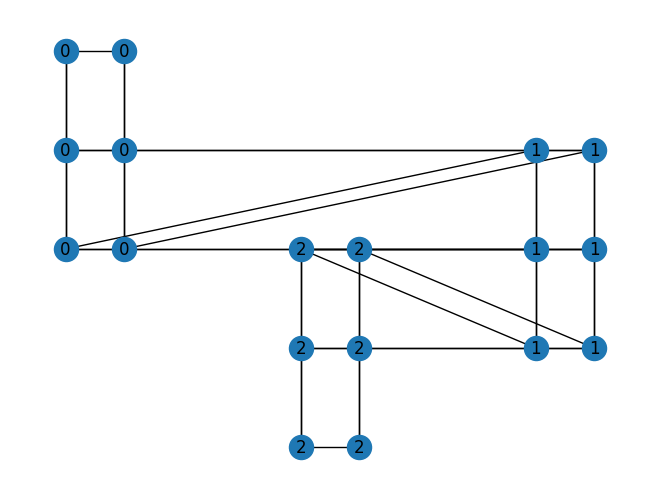

In [138]:
nx.draw(graph, pos_dict, labels=label_dict)

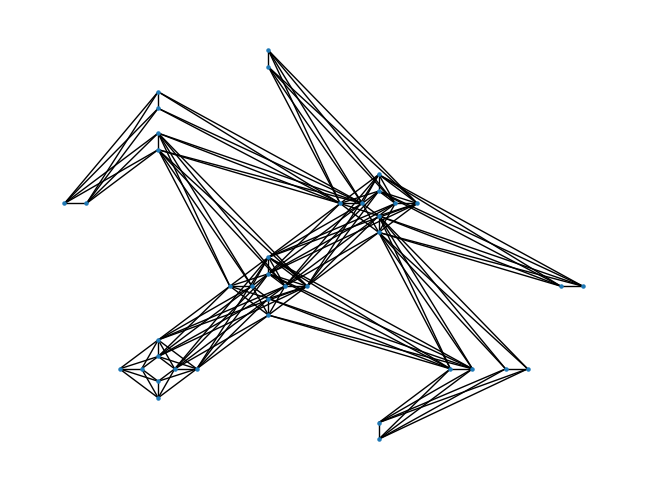

In [139]:
if hardware_type == 'chimera':
    target = dnx.chimera_graph(target_size) #create a SIZE,SIZE,4 chimera graph
    dnx.draw_chimera(target)
else:
    target = dnx.pegasus_graph(target_size)
    dnx.draw_pegasus(target, crosses=True, node_size=5)

In [140]:
if hardware_type == 'chimera':
  template, pos_template, left_shore, right_shore = build_template(4*target_size)
  print(f'number of nodes: {len(template.nodes)}')
  print(nx.is_bipartite(template))

  left, right = dwave.embedding.chimera.find_biclique_embedding(left_shore, right_shore, target_size, target_size)

## Default approach


In [94]:
embedding, size, max = default_embedding(target, graph)

In [141]:
embedding, size, max_chain =  default_embedding_iter(target, graph, n_iter=100)

In [142]:
np.sum(np.array(list(sizes.keys())) * np.array(list(sizes.values())))/100

35.59

<BarContainer object of 3 artists>

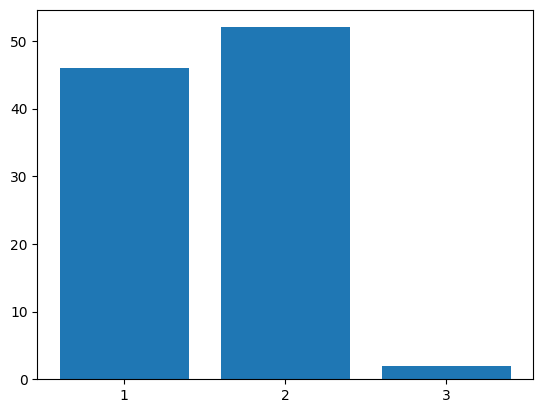

In [143]:
plt.bar(max_chain.keys(), max_chain.values(), tick_label = list(max_chain.keys()))

<BarContainer object of 13 artists>

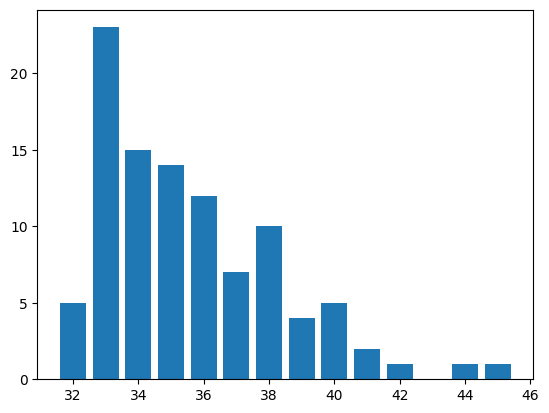

In [144]:
plt.bar(sizes.keys(), sizes.values())

In [ ]:
dnx.draw_pegasus_embedding(target, embedding, node_size=5, with_labels=False)

## IP one-problem approach

In [ ]:
#Model initialization
model = gb.Model("minor-embedding", env=env)

max_size = len(target.nodes)
min_size = len(graph.nodes)
print(f'Min_size: {min_size}')
print(f'Max_size: {max_size}')
k = 1

var_dict = define_decision_variables(target, graph, model)
model.update()

Min_size: 18
Max_size: 40


In [ ]:
print(f'Decision variables: {len(var_dict)}')

add_size_constraint(var_dict, model, max_size, min_size)
model.update()

c = len(list(model.getConstrs()))
print(f'Size constraints: {c}')

add_wd_constraint(target, graph, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Well Definition constraints: {c}')

add_fs_constraint(target, graph, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size constraints: {c}')

add_fs_refinement(target, graph, var_dict, model, k)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Size refinement: {c}')

add_pullback_constraint(target, graph, model, var_dict)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Pullback constraints: {c}')

add_fiber_constraint(graph, target, k, var_dict, model)
model.update()

c = len(list(model.getConstrs())) - c
print(f'Fiber Condition constraints: {c}')

Decision variables: 720
Size constraints: 2
Well Definition constraints: 40
Fiber Size constraints: 38
Fiber Size refinement: 11128
Pullback constraints: 5813
Fiber Condition constraints: 14080


In [ ]:
model.setObjective(sum(var_dict.values()), GRB.MINIMIZE)

In [ ]:
model.params.BestObjStop = 58

In [ ]:
model.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 19893 rows, 12200 columns and 990260 nonzeros
Model fingerprint: 0x2be5979e
Model has 11480 quadratic constraints
Variable types: 0 continuous, 12200 integer (12200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolved: 50410 rows, 23702 columns, 686390 nonzeros

Continuing optimization...

     0     0   18.00000    0  106   20.00000   18.00000  10.0%     -  310s
     0     0   18.00000    0  688   20.00000   18.00000  10.0%     -  316s
     0     0   18.00000    0  364   

In [ ]:
ip_embedding = {}

for j in graph:
    ip_embedding[j] = []
    for x, y in var_dict:
        if y == j:
            if var_dict[x,j].X > 0.5:
                ip_embedding[j].append(x)

In [ ]:
ip_embedding

{'x_2,1,3': [10],
 'x_1,0,3': [37],
 'x_2,1,2': [11],
 'x_1,0,2': [13, 30],
 'x_2,0,2': [36],
 'x_1,0,1': [9],
 'x_2,0,3': [15],
 'x_1,1,3': [41],
 'x_1,1,2': [40],
 'x_0,0,2': [8],
 'x_2,0,4': [14],
 'x_2,1,4': [35],
 'x_0,0,1': [39],
 'x_0,0,0': [38],
 'x_0,1,2': [7],
 'x_0,1,1': [43],
 'x_0,1,0': [42],
 'x_1,1,1': [6]}

In [ ]:
validate_embedding(ip_embedding, target, graph)

(True, True)

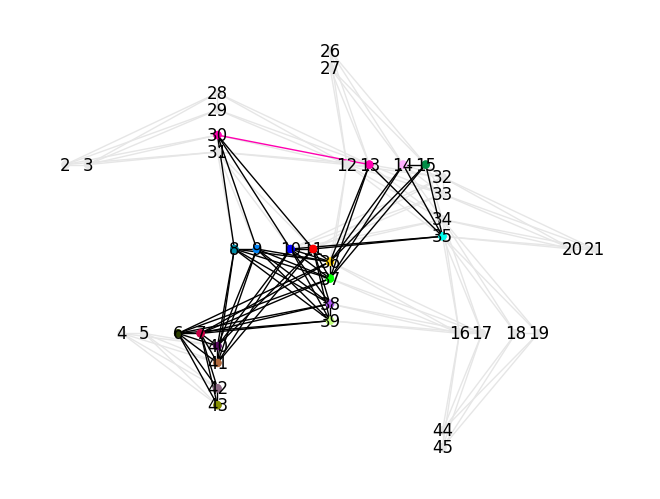

In [ ]:
dnx.draw_pegasus_embedding(target, ip_embedding, node_size=25,with_labels=True)

## Template approach

In [86]:
model = gb.Model("minor-embedding")
k = 2
y_dict, yp_dict = define_template_variables(graph, k, model)

In [87]:
add_association_constraint(y_dict, yp_dict, graph, model)
add_gsize_constraint(y_dict, graph, 4*size, k, model)
add_nsp_constraint(y_dict, graph, model)

In [88]:
model.setObjective(sum(yp_dict.values()), GRB.MAXIMIZE)

In [89]:
model.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 94 rows, 54 columns and 386 nonzeros
Model fingerprint: 0x6d21bb42
Variable types: 0 continuous, 54 integer (54 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 18.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 18 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%


In [90]:
embed = postprocess_template(y_dict)
embed

{'x_1,1,1': [(1, 0), (0, 0)],
 'x_0,0,1': [(1, 1), (0, 1)],
 'x_2,1,3': [(1, 2), (0, 2)],
 'x_2,0,3': [(1, 3), (0, 3)],
 'x_2,0,2': [(1, 4), (0, 4)],
 'x_1,0,3': [(1, 5), (0, 5)],
 'x_1,1,3': [(1, 6), (0, 6)],
 'x_0,0,2': [(1, 7), (0, 7)],
 'x_0,0,0': [(1, 8), (0, 8)],
 'x_1,0,2': [(1, 9), (0, 9)],
 'x_1,1,2': [(1, 10), (0, 10)],
 'x_0,1,2': [(1, 11), (0, 11)],
 'x_2,1,2': [(1, 12), (0, 12)],
 'x_2,1,4': [(1, 13), (0, 13)],
 'x_1,0,1': [(1, 14), (0, 14)],
 'x_0,1,1': [(1, 15), (0, 15)],
 'x_2,0,4': [(1, 16), (0, 16)],
 'x_0,1,0': [(1, 17), (0, 17)]}

In [91]:
final = postprocess_temp_embed(embed, left, right)

In [92]:
validate_embedding(final, target, graph)

(True, True)

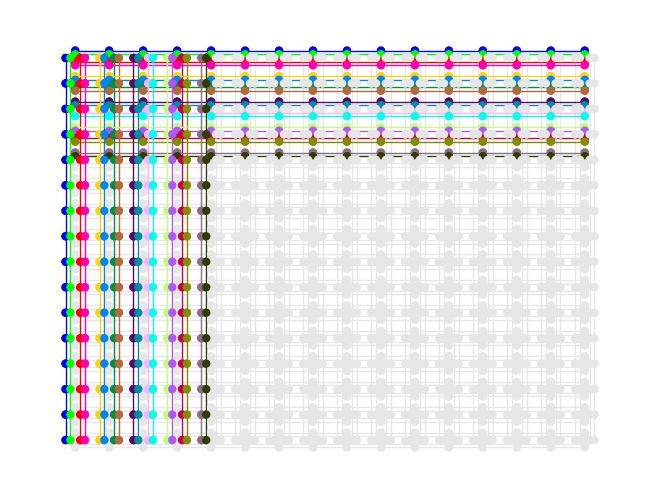

In [93]:
dnx.draw_chimera_embedding(target, final, node_size=25, with_labels=False)

# **Test emebdding**

In [ ]:
hardware_type = 'chimera'
target_size = 2

In [61]:
mode = 'generate'
n_instances = 100
save = True
path = '/content/drive/MyDrive/UNIPD_Projects/Quantum/Data/'

In [68]:
mode = 'load'
n_instances = 100
path = '/content/drive/MyDrive/UNIPD_Projects/Quantum/Data/'

In [69]:
n_jobs = 2
n_machines = 3
max_duration = 1
timespan = 5

In [ ]:
n_jobs = 3
n_machines = 3
max_duration = 1
timespan = 5

## Initialization

In [59]:
if mode == 'generate'
  instance_dict = {}
  for i in range(n_instances):
    instance_dict[i] = {}

    instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)
    var_dict = qubo_var_dict(instance)
    var_dict, ext_instance = simple_pruning(instance, var_dict)
    instance_dict[i]['instance'] = instance
    #build the model

    #add constraints, separating the full hamiltonian in smaller sub-hamiltonians
    #helps identifing wich constraint gets violated in case of non feasible solutions
    H = SubH(otm_cons(instance, var_dict), 'otm_cons')
    H += SubH(soo_cons(instance, var_dict), 'soo_cons')
    H += SubH(oo_cons(instance, var_dict), 'oo_cons')
    H += SubH(timespan_dis(instance, var_dict, K=5, energy_array=[0.8,0.4,0.1,0.05,0.1]), 'time_discrimination')
    model = H.compile()

    #generate bqm

    bqm = model.to_bqm()

    graph = bqm.to_networkx_graph()
    pos_dict, label_dict = generate_vis_dict(instance, graph)
    instance_dict[i]['graph'] = (graph,pos_dict,label_dict)

<ipython-input-59-a130f8b88796>:23: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  graph = bqm.to_networkx_graph()


In [67]:
if save and mode == 'generate':
  name = f'{n_instances}_J{n_jobs}_T{n_machines}_D{max_duration}_T{timespan}'

  with open(path+name, 'wb') as f:
    pickle.dump(instance_dict, f)

In [70]:
if mode == 'load':
  name = f'{n_instances}_J{n_jobs}_T{n_machines}_D{max_duration}_T{timespan}'

  with open(path+name, 'rb') as f:
    instance_dict = pickle.load(f)

In [161]:
if hardware_type == 'chimera':
    target = dnx.chimera_graph(target_size) #create a SIZE,SIZE,4 chimera graph
    #dnx.draw_chimera(target)
else:
    target = dnx.pegasus_graph(target_size)
    #dnx.draw_pegasus(target, crosses=True, node_size=5)

In [162]:
if hardware_type == 'chimera':
  template, pos_template, left_shore, right_shore = build_template(4*target_size)
  print(f'number of nodes: {len(template.nodes)}')
  print(nx.is_bipartite(template))

  left, right = dwave.embedding.chimera.find_biclique_embedding(left_shore, right_shore, target_size, target_size)

number of nodes: 16
True


# **Time-indexing solving**

## Instance generation

In [ ]:
# instance presented in Venturelli's work, here used for testing

instance = {
    0: [(0,2), (1,1), (2,1)],
    1: [(2,2), (0,1), (1,2)],
    2: [(1,1), (0,1), (2,2)],
    'timespan': 6
}

In [ ]:
instance = {
    0: [(0,2), (1,1)],
    1: [(1,2), (0,1)],
    'timespan': 6
}

In [ ]:
#generate random instance (machine, job, max duration, timespan)

n_jobs = 7
n_machines = 10
max_duration = 5
timespan = 10

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)

In [ ]:
instance = instance_from_file('/content/ft10.txt', 10)

## Solving

In [ ]:
#pruning

var_dict = qubo_var_dict(instance)
var_dict, ext_instance = simple_pruning(instance, var_dict)

In [ ]:
#build the model

#add constraints, separating the full hamiltonian in smaller sub-hamiltonians
#helps identifing wich constraint gets violated in case of non feasible solutions
H = SubH(otm_cons(instance, var_dict), 'otm_cons')
H += SubH(soo_cons(instance, var_dict), 'soo_cons')
H += SubH(oo_cons(instance, var_dict), 'oo_cons')
H += SubH(timespan_dis(instance, var_dict, K=5, energy_array=[0.8,0.4,0.1,0.05,0.1]), 'time_discrimination')
model = H.compile()

#generate bqm

bqm = model.to_bqm()

In [ ]:
graph = bqm.to_networkx_graph()
pos_dict, label_dict = generate_vis_dict(instance, graph)

<ipython-input-97-f7b9b83b841c>:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  graph = bqm.to_networkx_graph()


Text(2.5, 2.1, 'Job 3')

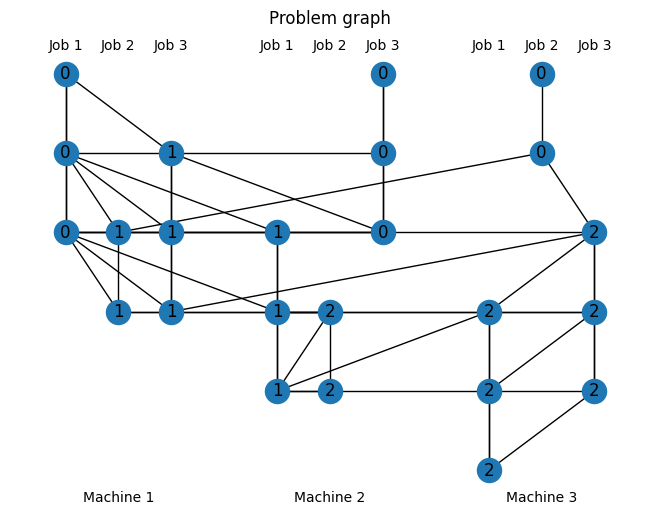

In [ ]:
nx.draw(graph, pos_dict, labels=label_dict)
plt.title('Problem graph')
plt.text(*(0.25,0.2),'Machine 1',ha='center')
plt.text(*(1.25,0.2),'Machine 2',ha='center')
plt.text(*(2.25,0.2),'Machine 3',ha='center')

plt.text(*(0,2.1),'Job 1',ha='center')
plt.text(*(0.25,2.1),'Job 2',ha='center')
plt.text(*(0.5,2.1),'Job 3',ha='center')

plt.text(*(1,2.1),'Job 1',ha='center')
plt.text(*(1.25,2.1),'Job 2',ha='center')
plt.text(*(1.5,2.1),'Job 3',ha='center')

plt.text(*(2,2.1),'Job 1',ha='center')
plt.text(*(2.25,2.1),'Job 2',ha='center')
plt.text(*(2.5,2.1),'Job 3',ha='center')
#nx.draw_networkx_labels(graph, pos_dict, label_dict)

### QPU solving

In [ ]:
#sample on QPU and standard embedding

dw = dwave.system.DWaveSampler(token=client_qpu.token, solver={'topology__type': 'pegasus'})
sampler = dwave.system.EmbeddingComposite(dw)

sampleset = sampler.sample(bqm,
      answer_mode="raw",
      num_reads=4500,
      annealing_time=40)

In [ ]:
#check energy of the best sample
solution = sampleset.first.sample
round(sampleset.first.energy,2)

1.3

In [ ]:
solution

# **Disjunctive Solving**

### Model Building

In [ ]:
model = gb.Model('JSS', env=env)

dec_dict, bin_dict, slack_dict = ilp_var_dict(instance, model)
model.update()

In [ ]:
prec_const(instance, model, dec_dict, slack_dict)
model.update()

In [ ]:
disj_const(instance, model, dec_dict, bin_dict, slack_dict)
model.update()

In [ ]:
C = makespan_cons(instance, model, dec_dict)
model.update()

In [ ]:
model.setObjective(C, GRB.MINIMIZE)
model.update()
obj_arr = np.array(model.Obj)

### Gurobi solving

In [ ]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 12 rows, 25 columns and 36 nonzeros
Model fingerprint: 0x18227a74
Variable types: 0 continuous, 25 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolved: 8 rows, 7 columns, 20 nonzeros

Continuing optimization...


Explored 1 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 2 (of 2 available processors)

Solution count 2: 3 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%


In [ ]:
solution = []
for v in model.getVars():
  if 'x_' in v.VarName:
    solution.append(v)

#solution = np.array(solution)

### GAMA algorithm

In [ ]:
#NEXT: testing

In [ ]:
# test matrix with knwon graver basis

A = np.array([[1,1,1,1],[1,5,10,25]])

In [ ]:
A = np.array([[2,1,1,0,0,0],[0,1,0,2,1,0],[0,0,1,0,1,2]])

In [ ]:
A = np.array([[1,2,3,5],[15,13,11,7]])

In [ ]:
A = model.getA().toarray()
pd.DataFrame(A)

In [ ]:
import sys

In [ ]:
def build_graver_model(Q,c):
  X = pyqubo.Array.create('X', shape=Q.shape[0], vartype='BINARY')
  exp = X @ Q @ X + c
  m = exp.compile()

  return m

In [ ]:
#FULL GRAVER BASIS EXTRACTION CYCLE

print('Init')
# given A and a first initialization of lower and upper
if 'basis' in locals():
  del basis

name = 'Instance_test_1'

# initial upper - lower bounds of variables
n = A.shape[1]
upper = np.zeros(n)
lower = np.zeros(n)
for i in range(len(upper)):
  upper[i] = 10
  lower[i] = -10

sampler = sampler = neal.SimulatedAnnealingSampler()

#dw = dwave.system.DWaveSampler(token=client_qpu.token, solver={'topology__type': 'pegasus'})
#sampler = dwave.system.EmbeddingComposite(dw)

max_iter = 300
near_optimal_extraction = 1
keep = 500
max_no_imp_iter = 10

len_basis = 0
no_imp_counter = 0
print('-------------------------------------------------')
for i in range(max_iter):
  print(f'Iteration {i}')

  #Encoding, QUBO matrix, and model generation
  Q, c, E, real_upper = build_graver_qubo(A, upper, lower, encoding='bin')
  X = pyqubo.Array.create('X', shape=Q.shape[0], vartype='BINARY')
  exp = X @ Q @ X + c
  m = exp.compile()

  #sample solutions
  print(' sampling')
  sampleset = sampler.sample(m.to_bqm(),
      answer_mode="raw",
      num_reads=500,
      annealing_time=500,
      label=f"{name}_{i}")

  print(' post-process sampleset')
  #retrieve the correct names ('X[i]') of each variable
  dec_sampleset = m.decode_sampleset(sampleset.aggregate())
  #filter out the solution with energy > k-1
  f_solutions = filter_lower_energies(dec_sampleset, k=near_optimal_extraction+1)
  #bring each samples in the right order
  dec_solutions = decode_solutions(f_solutions)
  #go back to integer vectors from the binary encoding
  unencode_sampleset(dec_solutions, lower, E)

  energies = list(dec_solutions.keys())
  print(f' energies found: {energies}')
  print(' post-process near-optimal solutions')
  #update bounds
  if len(dec_solutions[1]['sample'])>0:
    upper, lower = adapt_range(dec_solutions[energies[1]]['sample'], real_upper, lower)

  #find lowest-energy solutions to initialize the vector
  for e in dec_solutions:
    if len(dec_solutions[e]['sample']) > 0:
      if e != 0:
        all_solutions = post_process_no_sols(A, dec_solutions[e]['sample'], k=e)
      else:
        all_solutions = dec_solutions[e]['sample']
      break

  #append all the other optimal solutions obtained via post-processing
  energies = list(dec_solutions.keys())
  for k in range(e+1,near_optimal_extraction+1):
    if k in energies:
      if len(dec_solutions[k]['sample']) > 0:
        new_solutions = post_process_no_sols(A, dec_solutions[k]['sample'], k=k)
        all_solutions = np.append(all_solutions, new_solutions, axis=0)

  #take solutions in range
  bool_upper = np.array([ all(s <= upper) for s in all_solutions  ])
  if len(bool_upper) > 0:
    all_solutions = all_solutions[bool_upper]

  bool_lower = np.array([ all(s >= lower) for s in all_solutions  ])
  if len(bool_lower) > 0:
    all_solutions = all_solutions[bool_lower]
  print(f'  number of solutions found: {len(all_solutions)}')
  print(' basis update')

  #update basis
  if len(all_solutions)>0:
    keep = min(len(all_solutions), keep)
    if 'basis' in locals():
      tmp = np.append(all_solutions[:keep], basis, axis = 0)
      basis = filter_graver(tmp)
      #basis = update_basis(all_solutions[:keep], basis)
    else:
      tmp = all_solutions[:keep]
      basis = filter_graver(tmp)

  #check exit condition
  if len(basis) == len_basis:
    no_imp_counter +=1
    print(' no improvement')
    if no_imp_counter == max_no_imp_iter:
      break
  else:
    print(f' basis incremented by: {len(basis) - len_basis} vectors')
    print(f' current total vectors: {len(basis)}')
    len_basis = len(basis)
    no_imp_counter = 0
  print('-------------------------------------------------')

Init
-------------------------------------------------
Iteration 0
 sampling
 post-process sampleset
 energies found: [0, 1]
 post-process near-optimal solutions
  number of solutions found: 133
 basis update
 basis incremented by: 132 vectors
 current total vectors: 132
-------------------------------------------------
Iteration 1
 sampling
 post-process sampleset
 energies found: [0, 1]
 post-process near-optimal solutions
  number of solutions found: 62
 basis update
 basis incremented by: 55 vectors
 current total vectors: 187
-------------------------------------------------
Iteration 2
 sampling
 post-process sampleset
 energies found: [0, 1]
 post-process near-optimal solutions
  number of solutions found: 56
 basis update
 basis incremented by: 39 vectors
 current total vectors: 226
-------------------------------------------------
Iteration 3
 sampling


In [ ]:
basis

array([[-6., -6., -6., ..., -2.,  0.,  3.],
       [-6., -6., -6., ...,  0.,  5., -5.],
       [-6., -6., -6., ..., -2., -1., -4.],
       ...,
       [ 6.,  6.,  3., ...,  2., -2.,  4.],
       [ 6.,  6.,  3., ...,  1.,  0., -1.],
       [ 6.,  6.,  6., ...,  4.,  2.,  0.]])

In [ ]:
kek = np.array([ all(s <= upper) for s in all_solutions  ])

In [ ]:
all_solutions[kek]

array([[-1., -1., -6., -1., -4., -4., -5.,  0., -4., -4.,  3., -1.,  2.,
         2., -3., -4., -3., -6., -3.,  3., -6.,  6.,  2.,  6.,  6.]])

In [ ]:
all_solutions.shape

(36, 25)

In [ ]:
update_basis(all_solutions[:keep], basis)

In [ ]:
def update_basis(candidates, basis):
  rm_list = set()
  add_list = set()
  candidates = filter_graver(candidates)
  for j,c in enumerate(candidates):
    #check if the candidate is a valid addition to the basis
    valid = True
    for i,b in enumerate(basis):
      if all(c == b):
        valid = False
      if (c @ b > 0) and all(np.abs(c) >= np.abs(b)):
        valid = False
    #if the candidate is valid, check for removals from the original basis
    if valid:
      add_list.add(j)
      for i,b in enumerate(basis):
        if any(c != b):
          if (c @ b > 0) and all(np.abs(c) <= np.abs(b)):
            rm_list.add(i)

  #apply changes
  print(f'  n addition: {len(add_list)}')
  print(f'  n addition: {len(rm_list)}')
  basis = np.delete(basis, list(rm_list),0)
  for a in add_list:
    basis = np.append(basis, np.expand_dims(candidates[j], axis=0), axis=0)

  return basis

In [ ]:
obj = np.array(model.Obj)

In [ ]:
set_model_for_feasible(dec_dict, instance)

In [ ]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to andrea.ditrani@studenti.unipd.it
Optimize a model with 12 rows, 25 columns and 36 nonzeros
Model fingerprint: 0xc4fa4100
Variable types: 0 continuous, 25 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 12 rows and 25 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.07 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000

In [ ]:
solution = []
for v in model.getVars():
    solution.append(v.X)
solution = np.array(solution)

In [ ]:
solution

array([ 0., -0.,  0.,  1.,  2.,  2.,  0.,  1.,  5.,  5.,  0.,  0.,  3.,
        3.,  0.,  0., -0., -0.,  0.,  3.,  3.,  0.,  6.,  3.,  0.])

In [ ]:
var_names = [n.VarName for n in model.getVars()]

In [ ]:
dict_sol = dict(zip(var_names, solution))

In [ ]:
for b in basis:
  if disj_obj(solution + b, obj) < disj_obj(solution, obj):
    dict_sol = dict(zip(var_names, solution + b))
    draw_solution(dict_sol)

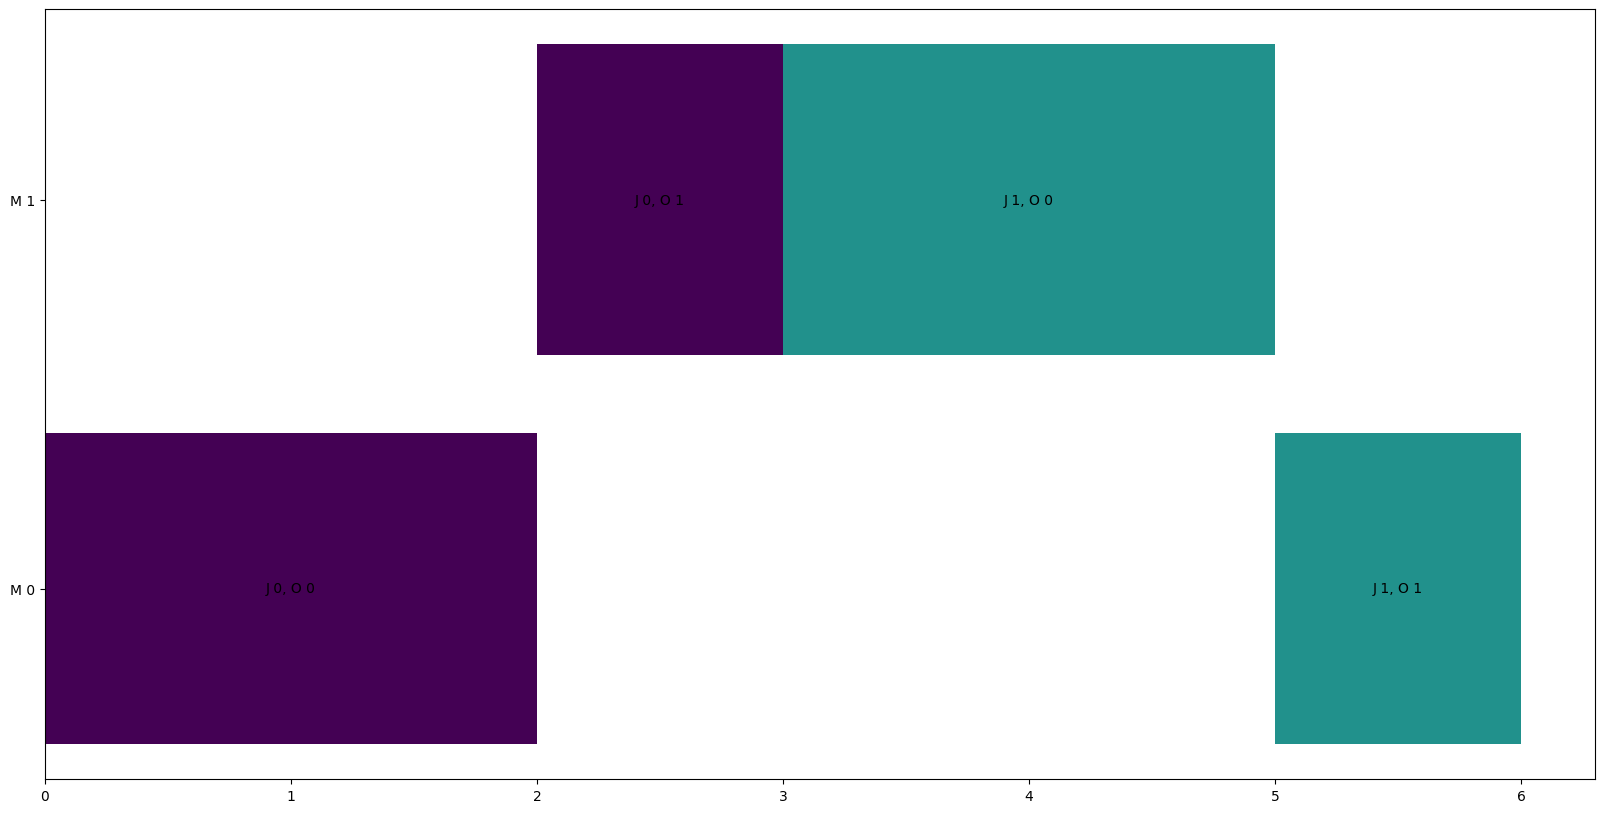

In [ ]:
draw_solution(dict_sol, instance, formulation='disj')

In [ ]:
slack_idx = []
for i in range(len(model.getVars())):
  if 's_' in model.getVars()[i].VarName:
    slack_idx.append(i)

In [ ]:
len(basis)

671

In [ ]:
i = 0
for b in basis:
  #if np.all(solution + b >= 0):
    print(disj_obj(solution+b,obj))
i

In [ ]:
opt = graver_augmentation(basis, solution, disj_obj, obj)

Starting value: 6.0


In [ ]:
disj_obj(opt, np.array(model.Obj))

2.0

In [ ]:
opt[slack_idx]

array([-0.,  2.,  5.,  3., -0., -0.,  0.,  3.,  3.,  0.,  3.,  0.])

In [ ]:
solution[slack_idx]

array([-0.,  2.,  5.,  3., -0., -0.,  0.,  3.,  3.,  0.,  3.,  0.])

In [ ]:
disj_obj(opt, np.array(model.Obj))

9.0

In [ ]:
opt[slack_idx]

array([-32.,  -1.,   0., -22.,  20., -23.,  29.,   0.,  -1.,  41., -11.,
        17.,  13.,  -7.,  -6.,  12.,  -1., -22.])

In [ ]:
# initial upper - lower bounds of variables
n = A.shape[1]
upper = np.zeros(n)
lower = np.zeros(n)
for i in range(len(upper)):
  upper[i] = 10
  lower[i] = -10


In [ ]:
#build matrix, constant and encoding
Q, c, E, real_upper = build_graver_qubo(A, upper, lower, encoding='bin')

In [ ]:
#BQM generation
X = pyqubo.Array.create('X', shape=Q.shape[0], vartype='BINARY')
exp = X @ Q @ X + c
m = exp.compile()
bqm = m.to_bqm()

In [ ]:
#BQM generation
X = pyqubo.Array.create('X', shape=Q.shape[0], vartype='BINARY')
exp = X @ Q @ X + c
m = exp.compile()
bqm = m.to_bqm()

In [ ]:
m.to_bqm().variables

In [ ]:
#QPU
dw = dwave.system.DWaveSampler(token=client_qpu.token, solver={'topology__type': 'pegasus'})
sampler = dwave.system.EmbeddingComposite(dw)

In [ ]:
#CLASSICAL
sampler = neal.SimulatedAnnealingSampler()

In [ ]:
sampleset = sampler.sample(bqm,
      answer_mode="raw",
      num_reads=1000,
      annealing_time=300)

In [ ]:
#retrieve the correct names ('X[i]') of each variable
dec_sampleset = m.decode_sampleset(sampleset.aggregate())
#filter out the solution with energy > k-1
f_solutions = filter_lower_energies(dec_sampleset, k=3)
#bring each samples in the right order
dec_solutions = decode_solutions(f_solutions)
#go back to integer vectors from the binary encoding
unencode_sampleset(dec_solutions, lower, E)

In [ ]:
A @ basis.T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **Visualization**

### Single solution

In [ ]:
var_dict

In [ ]:
nx.draw_networkx(graph, pos_dict)

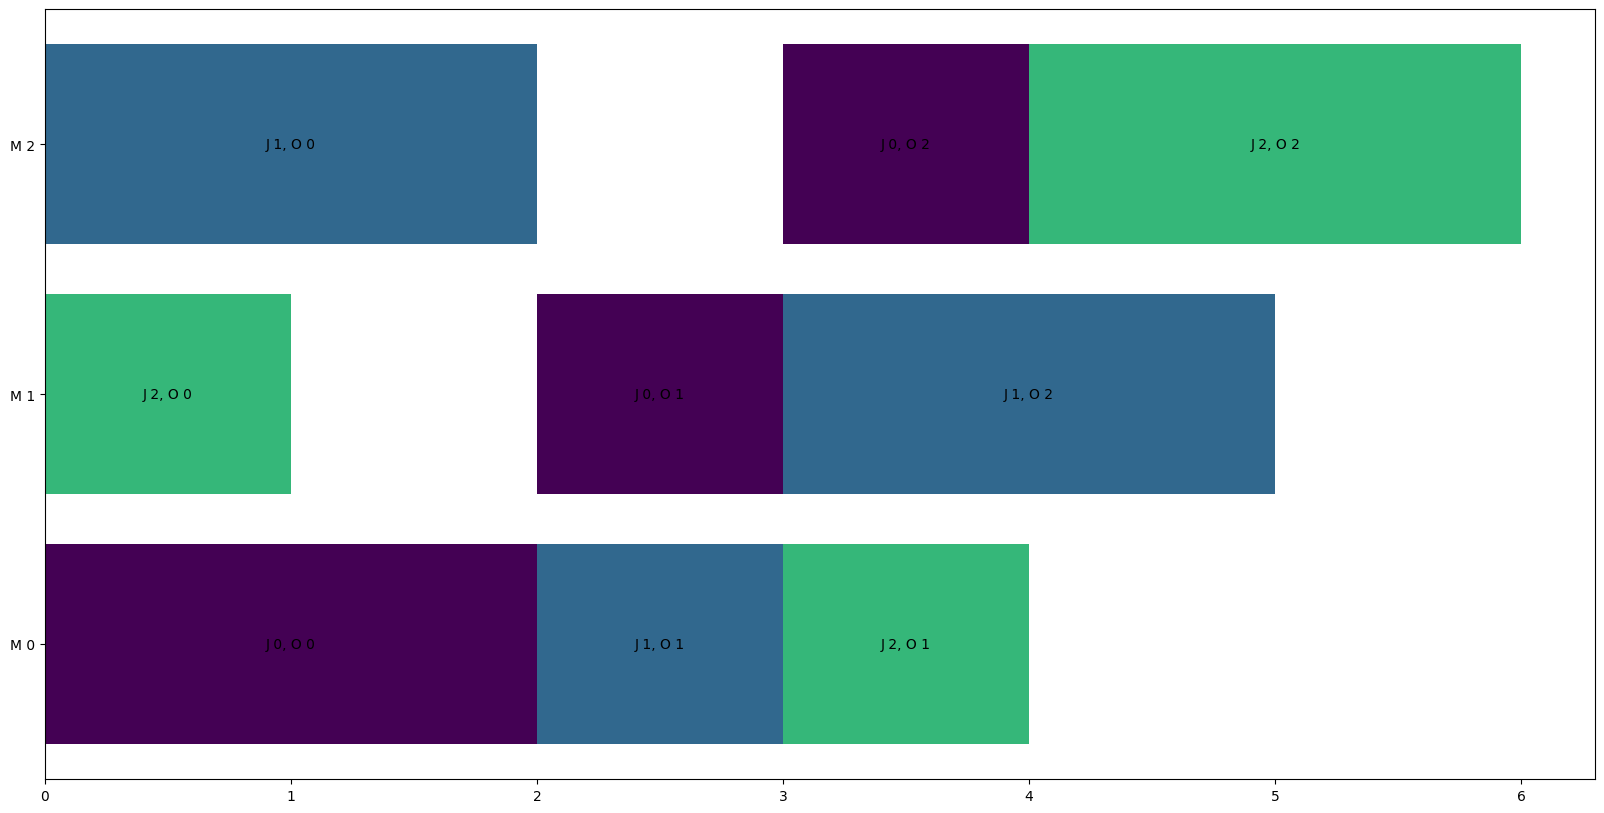

In [ ]:
#draw solution
draw_solution(solution, instance, formulation='time')

In [ ]:
#check wich constraint gets violated ('time_discrimination' is not a proper  constraint,
#it is a penalty added to longer makespans) ONLY FOR TIME-INDEXING FORMULATION

decoded = model.decode_sample(solution, vartype='BINARY')
decoded.subh

{'otm_cons': 0.0,
 'time_discrimination': 1.3000000000000003,
 'oo_cons': 0.0,
 'soo_cons': 0.0}